In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import sqrtm
from sklearn.linear_model import ElasticNet, Ridge

import sys
sys.path.insert(1, '../')
from saddle_point.experiments.learning_curve import LearningCurve

In [5]:
def get_mean(dimension=500, *, rho):
    mean = np.random.normal(0, 1, dimension) / np.sqrt(dimension)
        
    idx = np.random.choice(dimension, size=int((1-rho)*dimension), replace=False)
    mean[idx] = 0.
    
    return mean

def get_cov(dimension=500, *, rho, delta1, delta2):
    cov = delta1 * np.identity(dimension)
        
    idx = np.random.choice(dimension, size=int((1-rho)*dimension), replace=False)
    cov[idx, idx] = delta2
    
    return cov

In [6]:
d = 500
lamb = 0.01

rho = 0.5

delta1 = 0.1
delta2 = 0.5

prob = 0.5

cov = get_cov(dimension=d, 
              rho=rho, 
              delta1=delta1, 
              delta2=delta2)

sqrtcov = sqrtm(cov)

## Replicas

In [7]:
experiment = LearningCurve(loss = 'square', 
                            penalty = 'l2', 
                            regularisation = lamb, 
                            variances = [delta1, delta2], 
                            ratios = [rho, 1-rho],
                            probability = prob,
                            damping=0.9,
                            verbose = True)

experiment.learning_curve(sc_range = np.linspace(0.01, 3, 50))

Running sample complexity: 0.01
Running sample complexity: 0.07102040816326531
Running sample complexity: 0.1320408163265306
Running sample complexity: 0.19306122448979593
Running sample complexity: 0.2540816326530612
Running sample complexity: 0.31510204081632653
Running sample complexity: 0.37612244897959185
Running sample complexity: 0.43714285714285717
Running sample complexity: 0.4981632653061225
Running sample complexity: 0.5591836734693878
Running sample complexity: 0.6202040816326531
Running sample complexity: 0.6812244897959184
Running sample complexity: 0.7422448979591837
Running sample complexity: 0.8032653061224491
Running sample complexity: 0.8642857142857143
Running sample complexity: 0.9253061224489797
Running sample complexity: 0.986326530612245
Running sample complexity: 1.0473469387755103
Running sample complexity: 1.1083673469387756
Running sample complexity: 1.1693877551020408
Running sample complexity: 1.230408163265306
Running sample complexity: 1.2914285714285716

In [8]:
theory = experiment.get_curve()

In [22]:
# theory.to_csv('../data/theory/ridge_rho={}_delta1={}_delta2={}_lamb={}_prob={}.csv'.format(rho, delta1, delta2, lamb, prob), index=False)

## Simulations

In [9]:
def get_samples(*, n, mean, sqrtcov, prob):
    
    y = np.random.choice([1,-1], n, p = [prob, 1-prob])
    X = y.reshape(n,1) @ mean.reshape(1,d) + np.random.normal(0,1,(n,d)) @ sqrtcov.T
            
    return X/np.sqrt(d), y

In [14]:
def get_errors(*, samples, prob, lamb, seeds, sqrtcov, rho, penalty):
    '''
    Get averaged training and test error over a number of seeds for a fixed 
    number of samples.
    '''
    
    eg, et, q_tab, m_tab, b_tab = [], [], [], [], []
    
    cov = sqrtcov @ sqrtcov
    
    for i in range(seeds):
        print('Seed: {}'.format(i))
        
        mean = get_mean(rho=1)

        # Randomly subsample a set of indices (without replacement)
        X_train, y_train = get_samples(n=samples, 
                                       sqrtcov=sqrtcov, 
                                       mean=mean,
                                       prob=prob)
        
        X_test, y_test = get_samples(n=1000, 
                                     sqrtcov=sqrtcov, 
                                     mean=mean,
                                     prob=prob)


        clf = Ridge(alpha=lamb, 
                    fit_intercept=True, 
                    tol=1e-7, 
                    max_iter=1e4).fit(X_train, y_train)

        w, b = clf.coef_, clf.intercept_
            
        # Label estimate
        yhat_train = (X_train @ w + b)
        yhat_test = np.sign(X_test @ w + b)

        # Errors
        test_error = .25 * np.mean((yhat_test-y_test)**2)
        train_loss = .5 * np.mean((yhat_train-y_train)**2)
        
        q = w.dot(cov @ w) / d        
        m = mean.dot(w) / np.sqrt(d)
                
        eg.append(test_error)
        et.append(train_loss)
        
        q_tab.append(q)
        m_tab.append(m)
        b_tab.append(b)

    return (np.mean(et), np.std(et), np.mean(eg), np.std(eg),
            np.mean(q_tab), np.std(q_tab), 
            np.mean(m_tab), np.std(m_tab),
            np.mean(b_tab), np.std(b_tab)
           )

In [15]:
def simulate(seeds=10, prob=.5, *, sc_range, lamb, sqrtcov, rho):

    data = {'test_error': [], 'train_loss': [], 'test_error_std': [], 
            'train_loss_std': [], 'lambda': [], 'probability': [],
            'sample_complexity': [], 'samples': [], 'rho': [], 'penalty': [],
            'q': [], 'q_std': [], 'm': [], 'm_std': [], 'b': [], 'b_std': []}
    
    for alpha in sc_range:
        print('Simulating sample complexity: {}'.format(alpha))
        samples = int(alpha * d)
        et, et_std, eg, eg_std, q, q_std, m, m_std, b, b_std = get_errors(samples=samples, 
                                                                prob=prob, 
                                                                lamb=lamb, 
                                                                seeds=seeds, 
                                                                sqrtcov=sqrtcov,
                                                                rho=rho,
                                                                penalty=penalty)
        
        data['sample_complexity'].append(alpha)
        data['samples'].append(samples)
        data['probability'].append(prob)
        data['rho'].append(rho)
        data['penalty'].append('l2')
        
        data['lambda'].append(lamb)

        data['test_error'].append(eg)
        data['test_error_std'].append(eg_std)
        data['train_loss'].append(et)
        data['train_loss_std'].append(et_std)

        data['q'].append(q)
        data['q_std'].append(q_std)

        data['m'].append(m)
        data['m_std'].append(m_std)

        data['b'].append(b)
        data['b_std'].append(b_std)
        
    return pd.DataFrame.from_dict(data)

In [16]:
sc_range = np.linspace(0.1, 3, 10)
l2 = simulate(sc_range=sc_range, 
                lamb=lamb, 
                sqrtcov=sqrtcov, 
                rho=rho,
                seeds=10)

Simulating sample complexity: 0.1
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.42222222222222217
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.7444444444444444
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.0666666666666667
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.3888888888888888
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.711111111111111
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 2.033333333333333
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 2.3555555555555556
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7


In [24]:
# l2.to_csv('../data/theory/sim_ridge_rho={}_delta1={}_delta2={}_lamb={}_prob={}.csv'.format(rho, delta1, delta2, lamb, prob), index=False)

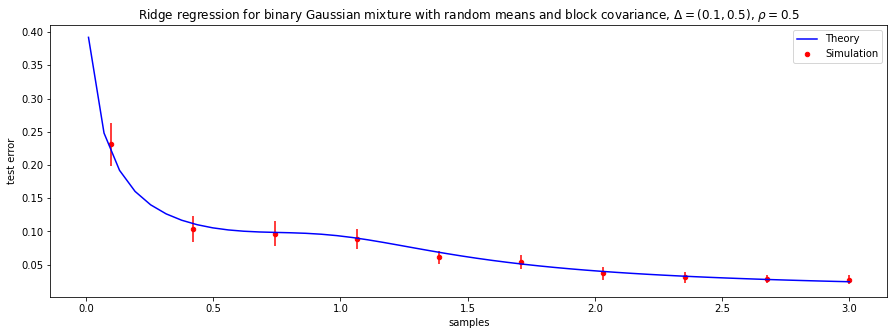

In [20]:
fig, ax = plt.subplots(figsize=(15,5))

plt.title(r'Ridge regression for binary Gaussian mixture with random means and block covariance, $\Delta = ({}, {})$, $\rho={}$'.format(delta1, delta2, rho))

l2.plot(x='sample_complexity', 
        y='test_error', 
        kind = 'scatter',
        yerr='test_error_std',
        ax=ax, 
        label='Simulation',
        c='r')

theory.plot(x='sample_complexity', 
        y='test_error', 
        ax=ax, 
        label='Theory',
        c='b')

plt.ylabel(r"test error")
plt.xlabel(r"samples")

plt.legend()
# plt.savefig('../data/plots/ridge_rho={}_delta1={}_delta2={}_lamb={}_prob={}.pdf'.format(rho, delta1, delta2, lamb, prob), bbox_inches='tight')